In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [133]:
titanic_data = pd.read_csv("train.csv")

In [134]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Смотрим какие данные были потеряны

In [135]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [136]:
X = titanic_data.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

Чтобы подготовить данные требуется предстваить в виде one hot encoding переменные формата string.
В случае с библиотекой pandas: pd.get_dummies(train) функция автоматически определяет какие значения принимать за 1, а какие за 0.
(Переменные которые имеют численный тип данных данная функция не преобразует)

---



In [137]:
X = pd.get_dummies(X)

В данной обучающей выборке все равно остались значения в столбце Age неопределенные, поэтому модель не может обучиться, чтобы это исправить воспользуемся заполнением всех неопределенных строк медианным значением, pd.fillna(медианный возраст) 

In [138]:
X = X.fillna({"Age" : X.Age.median()})

In [139]:
X.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [140]:
y = titanic_data.Survived

Разбиваем данные на tain и test выборку

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

Создаем дерево, обучаем на тренировочной выборке и подбираем наилучшие параметры

In [142]:
new_clf = tree.DecisionTreeClassifier()
new_clf

DecisionTreeClassifier()

In [143]:
parameters = {"criterion" : ['gini', 'entropy'], 'max_depth' : range(1, 30)}

In [144]:
grid_search_cv_clf = GridSearchCV(new_clf, parameters, cv=5)

In [145]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [146]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 9}

In [147]:
best_clf = grid_search_cv_clf.best_estimator_

In [148]:
best_clf.score(X_test, y_test)

0.7649253731343284

Выводим метрики precision и recall

In [165]:
from sklearn.metrics import precision_score, recall_score
y_pred = best_clf.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('precision = ', precision, 'recall = ', recall)

precision =  0.8351648351648352 recall =  0.6846846846846847


Прогнозируем вероятности классов для X_test.

In [169]:
y_predicted_prob = best_clf.predict_proba(X_test)

<Axes: >

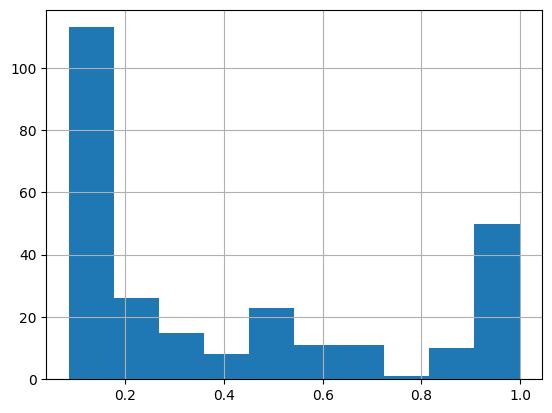

In [170]:
pd.Series(y_predicted_prob[:,1]).hist()

In [171]:
y_pred = np.where(y_predicted_prob[:,1] >.5, 1, 0)

In [172]:
precision_score(y_test, y_pred)

0.8351648351648352

In [173]:
recall_score(y_test, y_pred)

0.6846846846846847

ROC-кривая

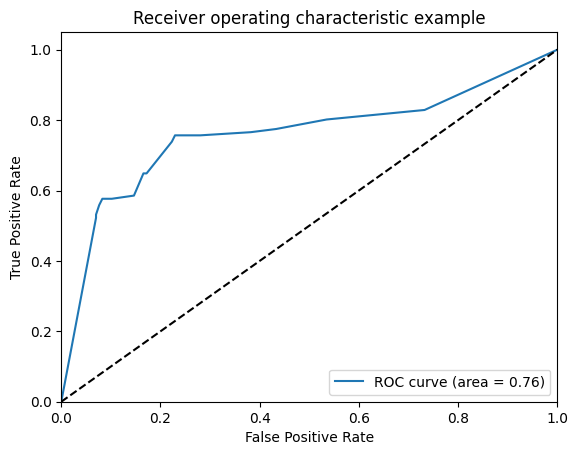

In [155]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Создаем Random forest, обучаем на тренировочной выборке и подбираем наилучшие параметры

In [156]:
clf_rf = RandomForestClassifier()
parameters = {'n_estimators': [10, 20, 30], 'max_depth' : [2, 5, 7, 10]}


In [157]:
grid_dearch_cv_clf = GridSearchCV(clf_rf, parameters, cv=5)

In [158]:
grid_dearch_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [10, 20, 30]})

In [159]:
grid_dearch_cv_clf.best_params_

{'max_depth': 5, 'n_estimators': 30}

In [160]:
best_clf = grid_dearch_cv_clf.best_estimator_
best_clf

RandomForestClassifier(max_depth=5, n_estimators=30)

In [161]:
best_clf.score(X_test, y_test)

0.8134328358208955

Вывод фич 

In [162]:
feature_impotrances = best_clf.feature_importances_

In [163]:
feature_impotrances_df = pd.DataFrame({'faeture':list(X_test), 
                                       'feature_impotrances' : feature_impotrances})

In [164]:
feature_impotrances_df.sort_values('feature_impotrances', ascending=False)

,faeture,feature_impotrances
5,Sex_female,0.313241
6,Sex_male,0.211433
4,Fare,0.131416
0,Pclass,0.122715
1,Age,0.108150
2,SibSp,0.039007
3,Parch,0.027457
7,Embarked_C,0.019327
9,Embarked_S,0.018591
8,Embarked_Q,0.008662
